###### <b> 1 . Importing Libraries</b>

In [ ]:
import os                               
import cv2
import time                              
import numpy as np  
from PIL import Image
import tensorflow as tf 
from google.colab import drive
from keras import backend as K           
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import sklearn.metrics as metrics
from keras.models import load_model
from skimage.transform import resize
from keras.preprocessing import image  
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

###### <b> 2. Mounting Google Drive</b>

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


######<b> 3 . Set Path for Training, Testing and Validation Directories</b>

In [ ]:
base_dir = '/content/drive/MyDrive/Skin cancer dataset'
train_dir = '/content/drive/MyDrive/Skin cancer dataset/train'
validations_dir = '/content/drive/MyDrive/Skin cancer dataset/validation'
test_dir = '/content/drive/MyDrive/Skin cancer dataset/test'

In [ ]:
train_benign_dir = '/content/drive/MyDrive/Skin cancer dataset/train/benign'
train_malignant_dir = '/content/drive/MyDrive/Skin cancer dataset/train/malignant'

validation_benign_dir = '/content/drive/MyDrive/Skin cancer dataset/validation/benign'
validation_malignant_dir = '/content/drive/MyDrive/Skin cancer dataset/validation/malignant'

test_benign_dir = '/content/drive/MyDrive/Skin cancer dataset/test/benign'
test_malignant_dir = '/content/drive/MyDrive/Skin cancer dataset/test/malignant'

In [ ]:
num_benign_train = len(os.listdir(train_benign_dir))
num_malignant_train = len(os.listdir(train_malignant_dir))

num_benign_validaition = len(os.listdir(validation_benign_dir))
num_malignant_validation= len(os.listdir(validation_malignant_dir))

num_benign_test = len(os.listdir(test_benign_dir))
num_malignant_test= len(os.listdir(test_malignant_dir))

In [ ]:
print("Total Training Benign Images",num_benign_train)
print("Total Training Malignant Images",num_malignant_train)
print("--")
print("Total validation Benign Images",num_benign_validaition)
print("Total validation Malignant Images",num_malignant_validation)
print("--")
print("Total Test Benign Images", num_benign_test)
print("Total Test Malignant Images",num_malignant_test)

Total Training Benign Images 1149
Total Training Malignant Images 937
--
Total validation Benign Images 300
Total validation Malignant Images 260
--
Total Test Benign Images 360
Total Test Malignant Images 300


In [ ]:
total_train = num_benign_train+num_malignant_train
total_validation = num_benign_validaition+num_malignant_validation
total_test = num_benign_test+num_malignant_test
print("Total Training Images",total_train)
print("--")
print("Total Validation Images",total_validation)
print("--")
print("Total Testing Images",total_test)

Total Training Images 2086
--
Total Validation Images 560
--
Total Testing Images 660


###### <b> 4 . Defining batch and image Size for model training</b>

In [ ]:
IMG_SHAPE  = 224
batch_size = 32

###### <b> 5 . Function for displaying Random Images</b>

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.axis("off")
    plt.show()

###### <b>6 . Applying Data Augmentation and Pre-Processing on training Data</b>

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255,rotation_range = 90,
                                     width_shift_range=0.3,height_shift_range=0.3,
                                     shear_range = 0.3,zoom_range = 0.2,
                                     horizontal_flip = True,vertical_flip = True,
                                     fill_mode = 'nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'binary')

Found 2086 images belonging to 2 classes.


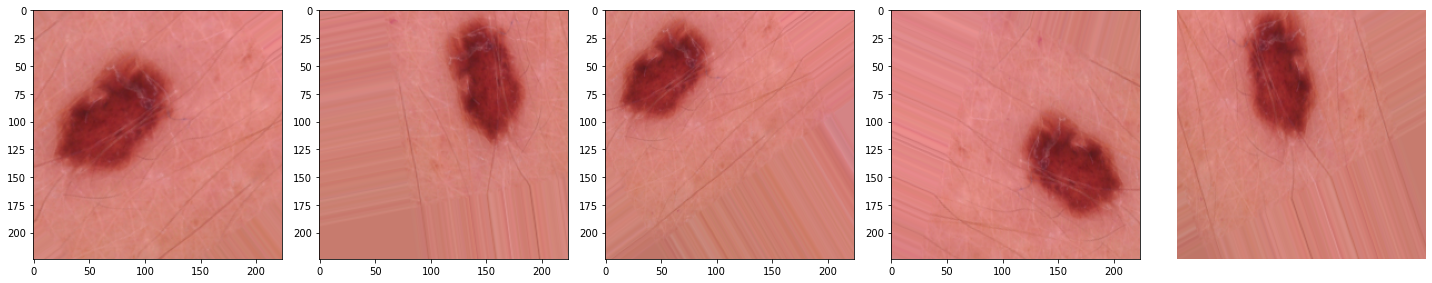

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

###### <B> 7 . Applying pre-processing on validation & Testing Data</b>

In [ ]:
image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
                                                 directory=validations_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                  class_mode='binary')

image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

Found 560 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


###### <b>8 . Names of classes</b>

In [ ]:
train_data_gen.classes

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

###### <b>9 . Setting Models Parameters</b>

In [ ]:
skin_classifier = tf.keras.Sequential([
        
        tf.keras.layers.Conv2D(16,(3,3),activation = tf.nn.relu,input_shape=(IMG_SHAPE,IMG_SHAPE, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(32,(3,3),activation = tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(64,(3,3),activation = tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(128,(3,3),activation = tf.nn.relu),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Dense(512, activation = "relu", kernel_regularizer=tf.keras.regularizers.l2(0.0000001)),
        tf.keras.layers.Dense(2,activation = tf.nn.sigmoid)  
])

###### <b> 10 . Compiling model parameters</b>

In [ ]:
skin_classifier.compile(optimizer='adam', loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=['acc'])

###### <b> 11 . Summary of model before training</b>

In [ ]:
skin_classifier.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_37 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 26, 26, 64)      

###### <b> 12 . Training</b>

In [ ]:
history_skin_classifier = skin_classifier.fit(train_data_gen,
                                              steps_per_epoch=65,
                                              epochs = 100,
                                              validation_data=val_data_gen,
                                              validation_steps=18,
                                              batch_size = batch_size,
                                              verbose = 1)

Epoch 1/100
65/65 [==============================] - 137s 2s/step - loss: 0.6506 - acc: 0.5910 - val_loss: 0.6163 - val_acc: 0.6804
Epoch 2/100
65/65 [==============================] - 134s 2s/step - loss: 0.5390 - acc: 0.7410 - val_loss: 0.5443 - val_acc: 0.7571
Epoch 3/100
65/65 [==============================] - 135s 2s/step - loss: 0.4740 - acc: 0.7740 - val_loss: 0.4278 - val_acc: 0.8179
Epoch 4/100
65/65 [==============================] - 134s 2s/step - loss: 0.4858 - acc: 0.7619 - val_loss: 0.4249 - val_acc: 0.8196
Epoch 5/100
65/65 [==============================] - 134s 2s/step - loss: 0.4565 - acc: 0.7780 - val_loss: 0.4415 - val_acc: 0.7857
Epoch 6/100
65/65 [==============================] - 134s 2s/step - loss: 0.4580 - acc: 0.7780 - val_loss: 0.4501 - val_acc: 0.8018
Epoch 7/100
65/65 [==============================] - 133s 2s/step - loss: 0.4980 - acc: 0.7644 - val_loss: 0.4832 - val_acc: 0.7643
Epoch 8/100
65/65 [==============================] - 133s 2s/step - loss: 0.

###### <b> 13 . Checking history of models parameters</b>

In [ ]:
history_dict = history_skin_classifier.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


##### <b> 14. Visualizing Accuracy and Loss results</b>

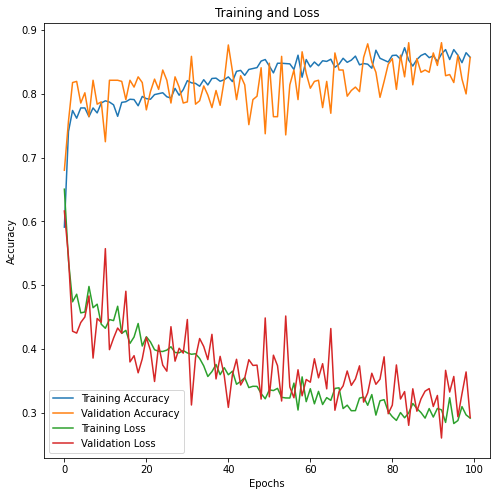

In [ ]:
acc = history_skin_classifier.history['acc']
val_acc = history_skin_classifier.history['val_acc']

loss = history_skin_classifier.history['loss']
val_loss = history_skin_classifier.history['val_loss']

epochs_range = range(100)
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='best')
plt.title('Training and Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

##### <B> 15 . Saving model</b>

In [ ]:
model_json = skin_classifier.to_json()
with open("/content/drive/MyDrive/Skin cancer dataset/Skin_cancer_classification.json", "w") as json_file:
    json_file.write(model_json)
skin_classifier.save("/content/drive/MyDrive/Skin cancer dataset/Skin_cancer_classification.h5")
print("Saved model to disk")
skin_classifier.save_weights("/content/drive/MyDrive/Skin cancer dataset/SCC-Weights.h5")

Saved model to disk


######<b> 16 . Model Evaluation</b>

In [ ]:
results = skin_classifier.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",results)

21/21 [==============================] - 12s 542ms/step - loss: 0.3078 - acc: 0.8530
test_loss, test accuracy [0.3078027069568634, 0.8530303239822388]


###### <b> 17 . Classification Matrix of Model Prediction</b>

In [ ]:
prediction = skin_classifier.predict(test_data_gen)
pred_class = np.argmax(prediction, axis=1)

true_classes = test_data_gen.classes
class_labels = list(test_data_gen.class_indices.keys())  
report = metrics.classification_report(pred_class,true_classes,target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      benign       0.53      0.55      0.54       351
   malignant       0.47      0.46      0.46       309

    accuracy                           0.50       660
   macro avg       0.50      0.50      0.50       660
weighted avg       0.50      0.50      0.50       660



###### <b>18 . Showing multiple images</b>

In [ ]:
lr_probs = skin_classifier.predict(test_data_gen)
lr_probs = lr_probs[:, 1]

In [ ]:
lr_precision, lr_recall, _ = precision_recall_curve(true_classes, lr_probs)

##### <b>19 . Visulazing Precision and Recall</b>

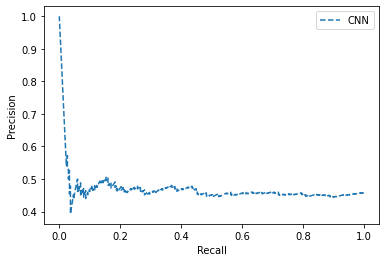

In [ ]:
no_skill = len(true_classes[true_classes==1]) / len(true_classes)
plt.plot(lr_recall, lr_precision, linestyle='--',label='CNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

#####<b>20 . Visualizing AUC & ROC Curves</b>

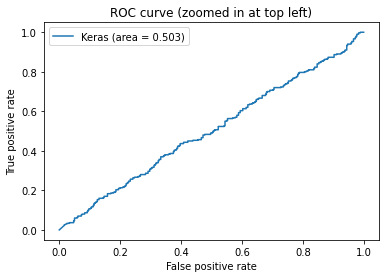

In [ ]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, lr_probs)
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()